# Cross-Feeding Simulation
Here we will simulate cross-feeding between two species of bacteria, inspired by previous work by [Dukovski et al., 2021](https://www.nature.com/articles/s41596-021-00593-3). For this purpose we will simulate two strains of *E. coli*: one which cannot uptake lactose and one which cannot metabolize galactose - with lactose being the only environmental carbon source being lactose set to a StaticConcentration.

In [74]:
from copy import deepcopy
import cobra
from process_bigraph import Composite
from process_bigraph import ProcessTypes
from process_bigraph.emitter import gather_emitter_results

from cdFBA import register_types
from cdFBA.processes.dfba import dFBA, UpdateEnvironment, StaticConcentration, Injector, WaveFunction

from cdFBA.utils import make_cdfba_composite, get_injector_spec, get_wave_spec, get_static_spec, set_concentration, set_kinetics

from matplotlib import pyplot as plt
from pprint import pprint

import cProfile
import pstats
import io


## Create Models
First we create E.coli models and save them in the sbml format. We start off with the `iAF1260` model for the K-12 *E. coli* strain, and use the knockout andCOBRApy

In [75]:
# #Load E. coli model
# E_no_galE = cobra.io.load_model("iAF1260")
# #Copy model
# E_no_LCTStex = E_no_galE.copy()
# #Knock out galactose metabolism
# E_no_galE.genes.b0759.knock_out() # cannot metabolize galactose
# #Knock out Lactose transport reaction LCTStex
# E_no_LCTStex.reactions.LCTStex.knock_out() # cannot uptake lactose

In [76]:
#save models in SBML format
# write_sbml_model(E_no_galE, "/Users/tasnifrahman/PycharmProjects/cdFBA/Notebooks/E_no_galE.xml")
# write_sbml_model(E_no_LCTStex, "/Users/tasnifrahman/PycharmProjects/cdFBA/Notebooks/E_no_LCTStex.xml")

In [77]:
#create model dictionary
model_dict = {
    'deltaGal':'E_no_galE.xml',
    'deltaLac':'E_no_LCTStex.xml'
}
#list exchange reactions
exchanges = ['EX_lcts_e', 'EX_gal_e']
#set volume
volume=2
# define a single dFBA model
spec = make_cdfba_composite(model_dict, medium_type=None, exchanges=exchanges, volume=volume, interval=0.01)
#print spec
pprint(spec)

{'Shared Environment': {'concentrations': {'D-Galactose': 10.0,
                                           'Lactose C12H22O11': 10.0,
                                           'deltaGal': 0.25,
                                           'deltaLac': 0.25},
                        'counts': {'D-Galactose': 20,
                                   'Lactose C12H22O11': 20,
                                   'deltaGal': 0.5,
                                   'deltaLac': 0.5},
                        'volume': 2},
 'Species': {'deltaGal': {'_type': 'process',
                          'address': 'local:dFBA',
                          'config': {'bounds': {},
                                     'changes': {'gene_knockout': [],
                                                 'reaction_knockout': []},
                                     'kinetics': {'D-Galactose': (0.5, 2.0),
                                                  'Lactose C12H22O11': (0.5,
                                       

In [78]:
#Set reaction bounds
spec['Species']['deltaGal']['config']['bounds'] = {
            "EX_o2_e": {"lower": -2, "upper": None},
            "ATPM": {"lower": 1, "upper": 1},
            'EX_glc__D_e': {"lower":0, "higher": 0}
        }
spec['Species']['deltaLac']['config']['bounds'] = {
            "EX_o2_e": {"lower": -2, "upper": None},
            "ATPM": {"lower": 1, "upper": 1},
            'EX_glc__D_e': {"lower":0, "higher": 0}
        }

In [79]:
#set external substrate concentrations
concentrations = {
    'D-Galactose': 0,
    'Lactose C12H22O11': 5
}
set_concentration(spec, concentrations)

In [80]:
#set kinetics
kinetics = {
    'Lactose C12H22O11': (0.5, 5),
    'D-Galactose': (0.5, 5)
}
for species in model_dict.keys():
    set_kinetics(species, spec, kinetics)
pprint(spec)

{'Shared Environment': {'concentrations': {'D-Galactose': 0,
                                           'Lactose C12H22O11': 5,
                                           'deltaGal': 0.25,
                                           'deltaLac': 0.25},
                        'counts': {'D-Galactose': 0,
                                   'Lactose C12H22O11': 10,
                                   'deltaGal': 0.5,
                                   'deltaLac': 0.5},
                        'volume': 2},
 'Species': {'deltaGal': {'_type': 'process',
                          'address': 'local:dFBA',
                          'config': {'bounds': {'ATPM': {'lower': 1,
                                                         'upper': 1},
                                                'EX_glc__D_e': {'higher': 0,
                                                                'lower': 0},
                                                'EX_o2_e': {'lower': -2,
                              

In [81]:
#set emitter specs
spec['emitter'] = {
        "_type": "step",
        "address": "local:ram-emitter",
        "config": {
            "emit": {
                "shared_environment": "any",
                "global_time": "any",
            }
        },
        "inputs": {
            "shared_environment": ["Shared Environment"],
            "global_time": ["global_time"]
        }
    }

In [82]:
#create the core object
core = ProcessTypes()
#register data types
core = register_types(core)
#register all processes and steps
core.register_process('dFBA', dFBA)
core.register_process('UpdateEnvironment', UpdateEnvironment)
core.register_process('StaticConcentration', StaticConcentration)
core.register_process('WaveFunction', WaveFunction)
core.register_process('Injector', Injector)

In [83]:
#create simulation composite
sim = Composite({
        "state": spec,
        },
        core=core
    )

In [84]:
#run simulation
sim.run(20)

In [85]:
#gather results
results = gather_emitter_results(sim)[('emitter',)]

In [86]:
#extract time-series data
timepoints = []
for timepoint in results:
    time = timepoint.pop('global_time')
    timepoints.append(time)
env = [timepoint['shared_environment']['concentrations'] for timepoint in results]
env_combined = {}
for d in env:
    for key, value in d.items():
        if key not in env_combined:
            env_combined[key] = []
        env_combined[key].append(value)

In [87]:
results

[{'shared_environment': {'concentrations': {'D-Galactose': 0,
    'Lactose C12H22O11': 5,
    'deltaGal': 0.25,
    'deltaLac': 0.25},
   'counts': {'D-Galactose': 0,
    'Lactose C12H22O11': 10,
    'deltaGal': 0.5,
    'deltaLac': 0.5},
   'volume': 2}},
 {'shared_environment': {'counts': {'D-Galactose': 0,
    'Lactose C12H22O11': 10,
    'deltaGal': 0.5,
    'deltaLac': 0.5},
   'concentrations': {'D-Galactose': 0.0,
    'Lactose C12H22O11': 5.0,
    'deltaGal': 0.25,
    'deltaLac': 0.25},
   'volume': 2}},
 {'shared_environment': {'counts': {'D-Galactose': 0,
    'Lactose C12H22O11': np.float64(10.0),
    'deltaGal': np.float64(0.5009877970389608),
    'deltaLac': np.float64(0.5)},
   'concentrations': {'D-Galactose': 0.0,
    'Lactose C12H22O11': np.float64(5.0),
    'deltaGal': np.float64(0.2504938985194804),
    'deltaLac': np.float64(0.25)},
   'volume': 2}},
 {'shared_environment': {'counts': {'D-Galactose': 0,
    'Lactose C12H22O11': np.float64(10.0),
    'deltaGal': np.fl

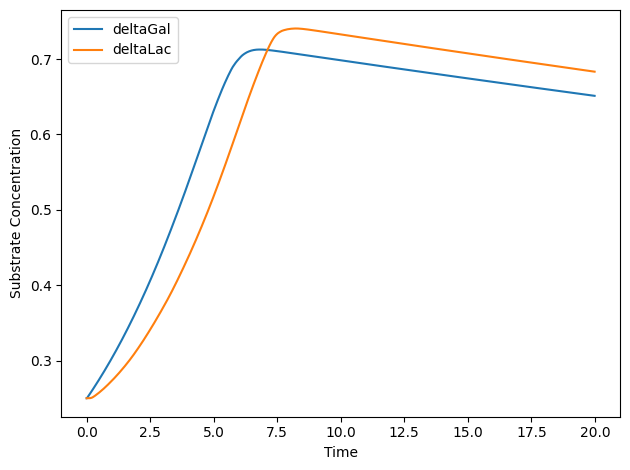

In [88]:
#plot results for biomass
fig, ax = plt.subplots(dpi=100)
for key, value in env_combined.items():
    if key not in ['Lactose C12H22O11', 'D-Galactose']:
        ax.plot(timepoints, env_combined[key], label=key)
plt.xlabel('Time')
plt.ylabel('Substrate Concentration')
plt.legend()
plt.tight_layout()
plt.show()

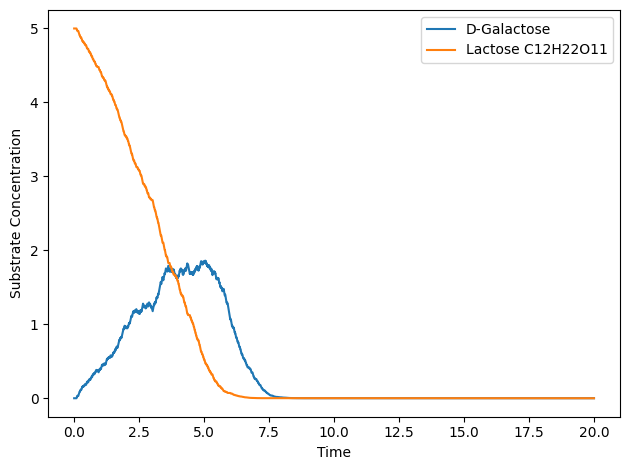

In [89]:
#plote substrates
fig, ax = plt.subplots(dpi=100)
for key, value in env_combined.items():
    if key in ['Lactose C12H22O11', 'D-Galactose']:
        ax.plot(timepoints, env_combined[key], label=key)
plt.xlabel('Time')
plt.ylabel('Substrate Concentration')
plt.legend()
plt.tight_layout()
plt.show()